### DETERMINE BEST METHOD TO DEAL WITH IMBALANCED DATA
When making predictions, we came across situations where prediction has to be done for a class that is not balanced. 
Conventional ML methods are going to be more inclined towards the majority class and ends up giving more predictions of a majority class compared to minority one. 
This in turn will give us a model with good precision but a poor recall. 
For credit card detection data, we will be running an ML Model with following approaches and evaluate them to decide the best approach
1. Keep data as is
2. Balance the data through Oversampling of minority class
3. Balance the data through Undersampling of majority class

In [1]:
#Importing Libraries

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import *
from sklearn.model_selection import GridSearchCV

#For Model Evaluation
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score,f1_score,classification_report,recall_score
from sklearn.preprocessing import label_binarize

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Correlation Matrix

<AxesSubplot:>

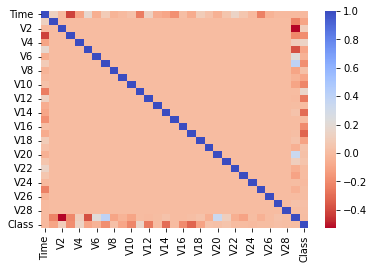

In [4]:
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})


In [5]:
#Top Five Features
x = corr['Class'].abs().sort_values(ascending = False).to_frame().query('Class < 1')
x.iloc[0:5]

,Class
V17,0.326481
V14,0.302544
V12,0.260593
V10,0.216883
V16,0.196539


### APPROACH 1: RUN ML MODEL WITHOUT MAKING ANY CHANGES TO IMPACT IMBALANCE OF DATA

In [6]:
new_df_cap=df.copy()
X = new_df_cap.drop(columns = ['Class'])
y = new_df_cap['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train = X_train.values
#X_test = X_test.values
#y_train = y_train.values
#y_test = y_test.values

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(227845, 30) (56962, 30) (227845,) (56962,)


In [7]:
unique, counts = np.unique(y_train, return_counts=True)
unique2, counts2 = np.unique(y_test, return_counts=True)

print("y_train value counts",np.asarray((unique, counts)).T)
print("y_test value counts",np.asarray((unique2, counts2)).T)

y_train value counts [[     0 227451]
 [     1    394]]
y_test value counts [[    0 56864]
 [    1    98]]


In [8]:
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
knn = KNeighborsClassifier( weights='distance').fit(X_train, y_train)
RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1).fit(X_train, y_train)

y_pred = list()
y_prob = list()

coeff_labels = ['logistics_regression', 'knn', 'random_forest']
coeff_models= [lr, knn, RF]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,logistics_regression,knn,random_forest
0,1,0,1
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [9]:
metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1]),
              label_binarize(y_pred[lab], classes=[0,1]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)
metrics

,logistics_regression,knn,random_forest
precision,0.998893,0.998422,0.999552
recall,0.998999,0.998420,0.999561
fscore,0.998891,0.997750,0.999535
accuracy,0.998999,0.998420,0.999561
auc,0.765209,0.540816,0.882635


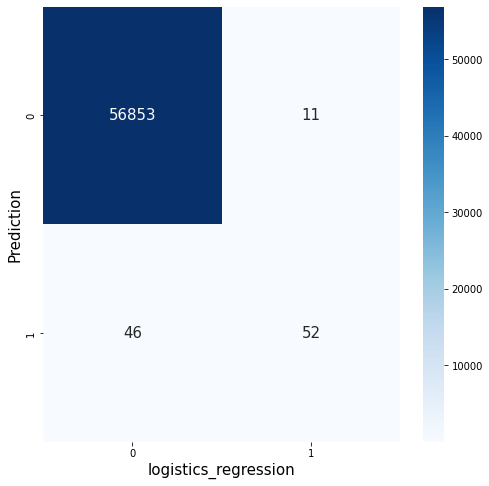

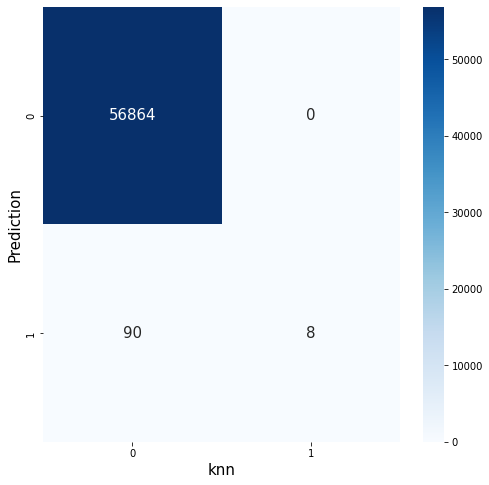

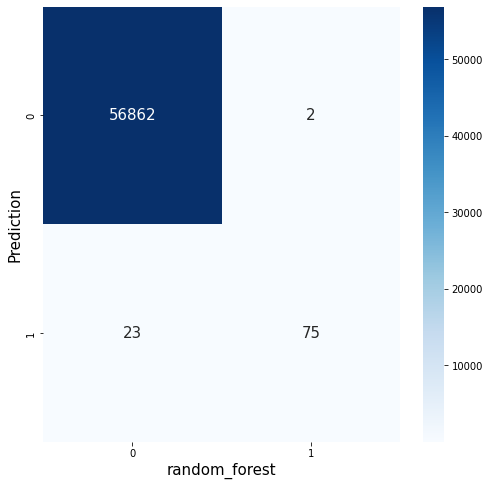

In [10]:
for cols in y_pred.columns:
    _, ax = plt.subplots(figsize=(8,8))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred[cols]), annot=True, fmt='d', annot_kws={"size": 15}, cmap = 'Blues')  
    #labels = [0, 'True']
    #ax.set_xticklabels(labels, fontsize=15);
    #ax.set_yticklabels(labels[::-1], fontsize=15);
    ax.set_ylabel('Prediction', fontsize=15);
    ax.set_xlabel(cols, fontsize=15)

Even though the precision and recall values look great, 
LR could correctly detect 47 frauds out of 98, KNN 7 and random forest 77.

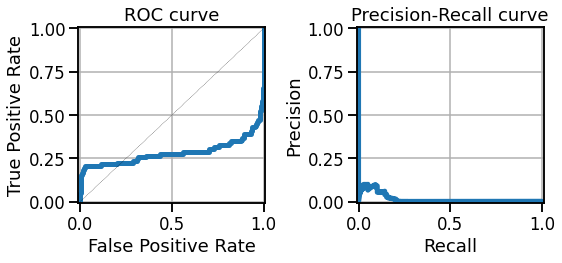

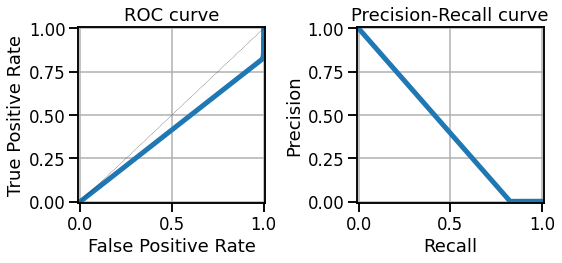

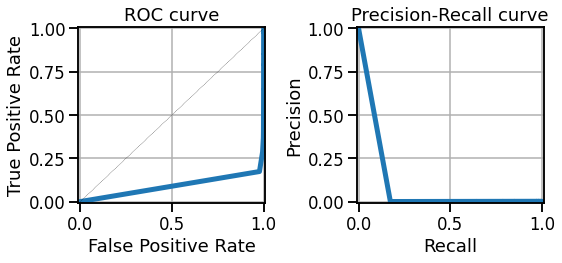

In [11]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

for cols in y_pred.columns:
    sns.set_context('talk')

    fig, axList = plt.subplots(ncols=2)
    fig.set_size_inches(8, 4)
    ax = axList[0]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[cols])
    ax.plot(fpr, tpr, linewidth=5)
# It is customary to draw a diagonal dotted line in ROC plots.
# This is to indicate completely random prediction. Deviation from this
# dotted line towards the upper left corner signifies the power of the model.
    ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           xlim=[-.01, 1.01], ylim=[-.01, 1.01],
           title='ROC curve')
    ax.grid(True)

# Plot the precision-recall curve
    ax = axList[1]

    precision, recall, _ = precision_recall_curve(y_test, y_prob[cols])
    ax.plot(recall, precision, linewidth=5)
    ax.set(xlabel='Recall', ylabel='Precision',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='Precision-Recall curve')
    ax.grid(True)

    plt.tight_layout()

## Balance the data through Oversampling of minority class
This can be done through RandomOverSampler. I will increase the data where the fraud cases will be over sampled. However we need to do this only on the training set. the test set needs to be the same for comparison purpose

In [12]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_over, y_over = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % (y_over.value_counts()))

Resampled dataset shape 0    227451
1    227451
Name: Class, dtype: int64


In [13]:
y_test.value_counts() # we keep it as is

0    56864
1       98
Name: Class, dtype: int64

In [14]:
lr_over = LogisticRegression(solver='liblinear').fit(X_over, y_over)
knn_over = KNeighborsClassifier( weights='distance').fit(X_over, y_over)
RF_over = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1).fit(X_over, y_over)


In [15]:
y_pred_over = list()
y_prob_over = list()

coeff_labels = ['logistics_regression', 'knn', 'random_forest']
coeff_models= [lr_over, knn_over, RF_over]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred_over.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob_over.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred_over = pd.concat(y_pred_over, axis=1)
y_prob_over = pd.concat(y_prob_over, axis=1)



In [16]:
metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred_over[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred_over[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1]),
              label_binarize(y_pred_over[lab], classes=[0,1]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred_over[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)
metrics

,logistics_regression,knn,random_forest
precision,0.998247,0.997273,0.999570
recall,0.983164,0.997437,0.999579
fscore,0.990058,0.997353,0.999555
accuracy,0.983164,0.997437,0.999579
auc,0.940635,0.596350,0.887738


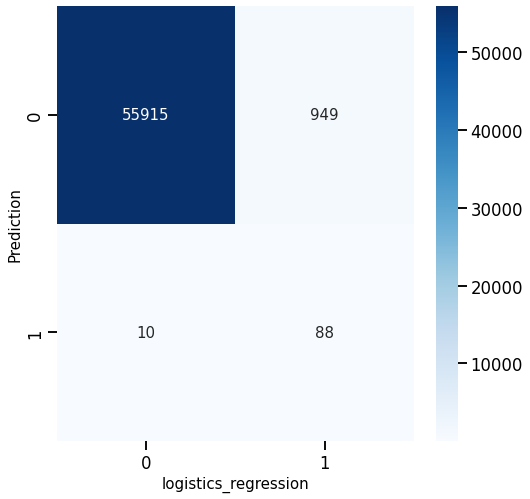

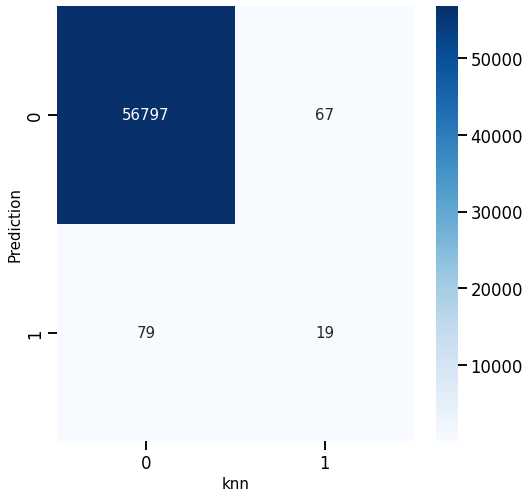

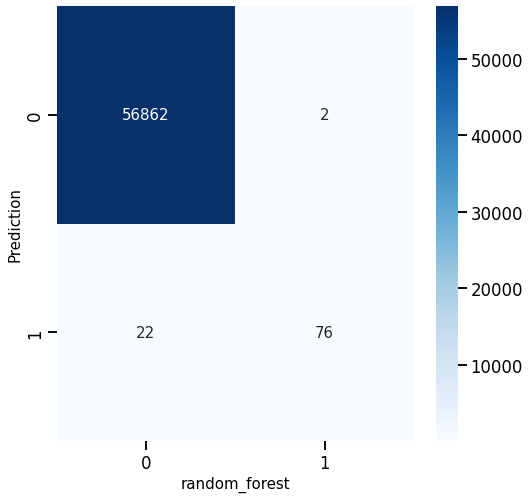

In [17]:
for cols in y_pred_over.columns:
    _, ax = plt.subplots(figsize=(8,8))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred_over[cols]), annot=True, fmt='d', annot_kws={"size": 15}, cmap = 'Blues')  
    #ax.set_xticklabels(labels, fontsize=15);
    #ax.set_yticklabels(labels[::-1], fontsize=15);
    ax.set_ylabel('Prediction', fontsize=15);
    ax.set_xlabel(cols, fontsize=15)

Oversampling does a better job at predicting fraud, LR predicts 89 out of 98 cases, KNN 16 and RF 76. However,due to oversampling, many of the non fraud cases are also marked as fraud by this model which is its biggest disadvantage

## Balance the data through Undersampling of majority class
This can be done through RandomUnderSampler. This will decrease the majority class, only problem is that the evidence to majority data decreases immensely. Let's see how good the model is with undersampling

In [18]:
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=0)
X_under, y_under = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % (y_under.value_counts()))

Resampled dataset shape 0    394
1    394
Name: Class, dtype: int64


In [19]:
lr_under = LogisticRegression(solver='liblinear').fit(X_under, y_under)
knn_under = KNeighborsClassifier( weights='distance').fit(X_under, y_under)
RF_under = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1).fit(X_under, y_under)

y_pred_under = list()
y_prob_under = list()

coeff_labels = ['logistics_regression', 'knn', 'random_forest']
coeff_models= [lr_under, knn_under, RF_under]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred_under.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob_under.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred_under = pd.concat(y_pred_under, axis=1)
y_prob_under = pd.concat(y_prob_under, axis=1)



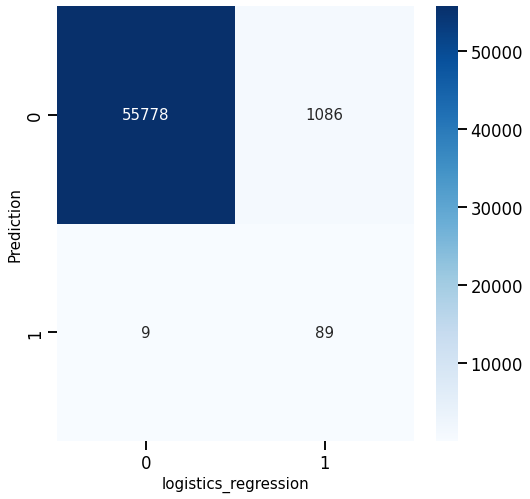

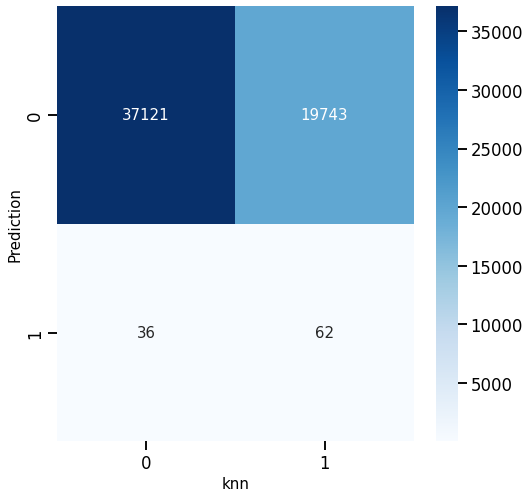

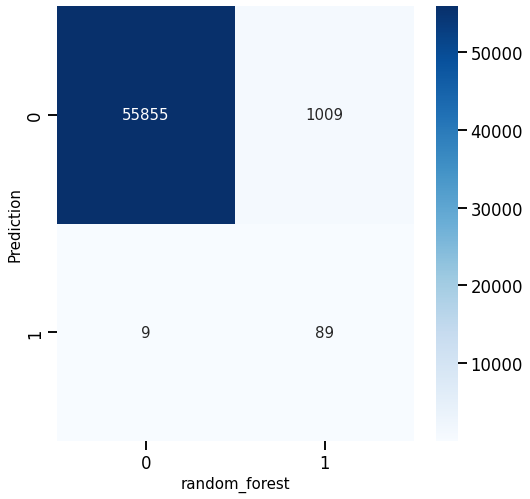

In [20]:
for cols in y_pred_under.columns:
    _, ax = plt.subplots(figsize=(8,8))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred_under[cols]), annot=True, fmt='d', annot_kws={"size": 15}, cmap = 'Blues')  
    #ax.set_xticklabels(labels, fontsize=15);
    #ax.set_yticklabels(labels[::-1], fontsize=15);
    ax.set_ylabel('Prediction', fontsize=15);
    ax.set_xlabel(cols, fontsize=15)

This is a good model to detect fraud, but a bad model overall due to less evidence. Again, we see many cases where it wasnt a fraud but this model predicted so

## APPLY SMOTE

Synthetic Minority Oversampling Technique, or SMOTE is the technique of synthesizing new examples from the minority class. This is different from oversampling as it adds new information. It takes on the examples that are close in the feature space,  drawing a line between the examples in the feature space and drawing a new sample at a point along that line.


In [21]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
X_smote, y_smote = sm.fit_resample(X_train, y_train)

In [22]:
y_smote.value_counts()

0    227451
1    227451
Name: Class, dtype: int64

In [23]:
lr_smote = LogisticRegression(solver='liblinear').fit(X_smote, y_smote)
knn_smote = KNeighborsClassifier( weights='distance').fit(X_smote, y_smote)
RF_smote = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1).fit(X_smote, y_smote)

y_pred_smote = list()
y_prob_smote = list()

coeff_labels = ['logistics_regression', 'knn', 'random_forest']
coeff_models= [lr_smote, knn_smote, RF_smote]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred_smote.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob_smote.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred_smote = pd.concat(y_pred_smote, axis=1)
y_prob_smote = pd.concat(y_prob_smote, axis=1)



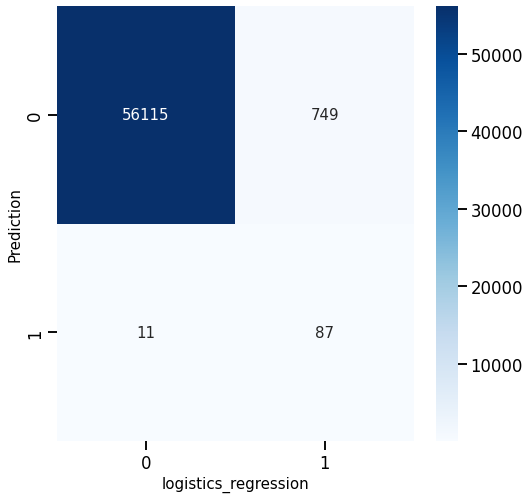

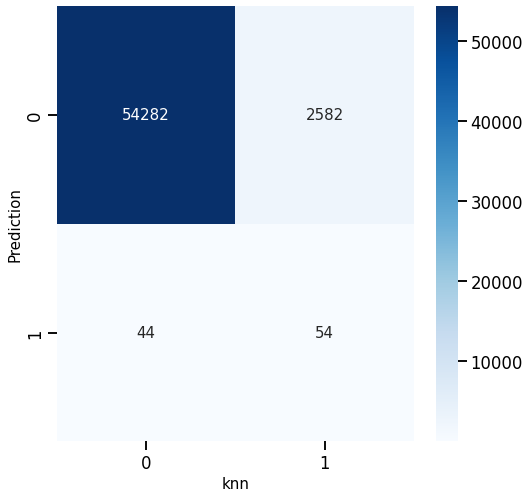

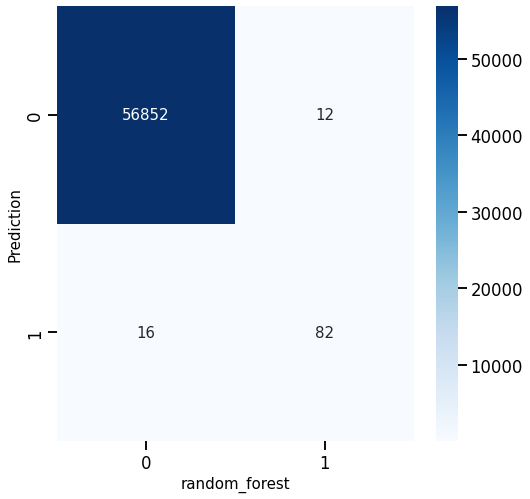

In [24]:
for cols in y_pred_smote.columns:
    _, ax = plt.subplots(figsize=(8,8))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred_smote[cols]), annot=True, fmt='d', annot_kws={"size": 15}, cmap = 'Blues')  
    #ax.set_xticklabels(labels, fontsize=15);
    #ax.set_yticklabels(labels[::-1], fontsize=15);
    ax.set_ylabel('Prediction', fontsize=15);
    ax.set_xlabel(cols, fontsize=15)

Except for random forest, SMOTE again incorrectly detects many non fraud cases as one. It's because many of the examples are synthesized and can present a weaker model.While generating synthetic examples, SMOTE does not take into consideration neighboring examples can be from other classes. This can increase the overlapping of classes and can introduce additional noise. One way to resolve this is by making a model with SMOTE + undersampling approach. 

In [25]:
from imblearn.pipeline import Pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_smote_under, y_smote_under = pipeline.fit_resample(X_train, y_train)

In [26]:
y_smote_under.value_counts()

0    227450
1     22745
Name: Class, dtype: int64

In [27]:
lr_smote_under = LogisticRegression(solver='liblinear').fit(X_smote_under, y_smote_under)
knn_smote_under = KNeighborsClassifier( weights='distance').fit(X_smote_under, y_smote_under)
RF_smote_under = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1).fit(X_smote_under, y_smote_under)

y_pred_smote_under = list()
y_prob_smote_under = list()

coeff_labels = ['logistics_regression', 'knn', 'random_forest']
coeff_models= [lr_smote_under, knn_smote_under, RF_smote_under]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred_smote_under.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob_smote_under.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred_smote_under = pd.concat(y_pred_smote_under, axis=1)
y_prob_smote_under = pd.concat(y_prob_smote_under, axis=1)



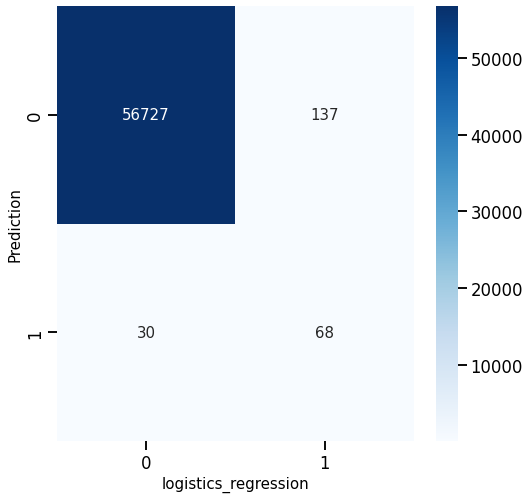

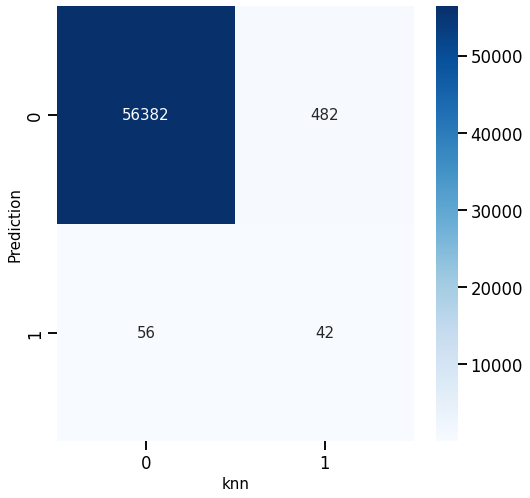

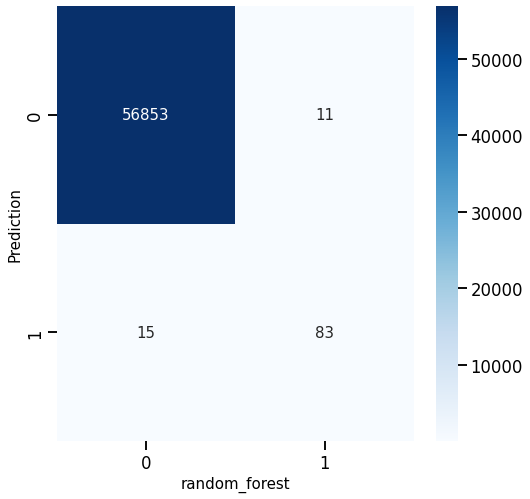

In [28]:
for cols in y_pred_smote_under.columns:
    _, ax = plt.subplots(figsize=(8,8))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred_smote_under[cols]), annot=True, fmt='d', annot_kws={"size": 15}, cmap = 'Blues')  
    #ax.set_xticklabels(labels, fontsize=15);
    #ax.set_yticklabels(labels[::-1], fontsize=15);
    ax.set_ylabel('Prediction', fontsize=15);
    ax.set_xlabel(cols, fontsize=15)

In [29]:
predictions = [y_pred, y_pred_over, y_pred_under, y_pred_smote, y_pred_smote_under]

scores = list()

for i in predictions:
    scores.append(score(y_test, i[lab], average='weighted'))

In [30]:
scores

[(0.9995516842152548, 0.9995611109160493, 0.999534818084207, None),
 (0.9995697994193833, 0.9995786664794073, 0.999554764115789, None),
 (0.998258179631256, 0.9821284365015274, 0.9895205574037292, None),
 (0.9994994994402474, 0.9995084442259752, 0.9995033324974358, None),
 (0.9995353563773838, 0.9995435553526912, 0.999538808747619, None)]